# EXAMPLE NOTEBOOK: Mean wind speed over China for 1851-1859
### Purpose of this notebook is to demonstrate doing a mean collapse over a 58GB dataset

In [1]:
import iris
import copy
import zarr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import crd_utils as crd

In [2]:
import getpass
account_key = getpass.getpass()

 ························································································


In [3]:
# zarr = '/data/cssp-china/zarr_daily_1851-1859/'
# zarr.storage.ABSStore(container, prefix='', account_name=None, account_key=None, blob_service_kwargs=None)

prefix_read ='zarr_hourly_1851-1859'
zarr_read = zarr.storage.ABSStore('cssp-china', prefix=prefix_read, account_name='awsearth', account_key=account_key, blob_service_kwargs=None)
print(f'/data/cssp-china/{prefix_read}')

/data/cssp-china/zarr_hourly_1851-1859


In [4]:
%%time
ds = xr.open_zarr(zarr_read)
ds

CPU times: user 1.02 s, sys: 10.6 ms, total: 1.03 s
Wall time: 2.97 s


<xarray.Dataset>
Dimensions:                  (grid_latitude: 219, grid_latitude_1: 218, grid_longitude: 286, grid_longitude_1: 286, time: 77329)
Coordinates:
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(577,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...
  * grid_latitude            (grid_latitude) float32 22.88 22.66 ... -25.08
  * grid_latitude_1          (grid_latitude_1) float32 22.77 ... -24.969997
  * grid_longitude           (grid_longitude) float32 323.48 323.7 ... 386.18002
  * grid_longitude_1         (grid_longitude_1) float32 323.59003 ... 386.29004
    height                   float64 ...
  * time                     (time) datetime64[ns] 1851-01-01 ... 1859-12-29
Data variables:
    surface_air_pressure     (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 219, 286), meta=np.ndarray>
    x_wind                   (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 218, 286), meta=np.ndarray>
    y_wind                   (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 218, 286), meta=np.ndarray>

In [5]:
# What is the size in GBs?
ds.nbytes / 1e9

57.945407596

## Convert the data to Iris cubes

In [6]:
%%time
xwind = ds.x_wind.to_iris()
ywind = ds.y_wind.to_iris()

display(xwind)
display(ywind)

<iris 'Cube' of x_wind / (m s-1) (time: 77329; grid_latitude: 218; grid_longitude: 286)>

<iris 'Cube' of y_wind / (m s-1) (time: 77329; grid_latitude: 218; grid_longitude: 286)>

CPU times: user 9.61 s, sys: 566 ms, total: 10.2 s
Wall time: 13 s


### Using dask_distributed, let's compute the rolling mean

In [9]:
import os
import distributed
import dask
from dask_kubernetes import KubeCluster
from dask import array as da

In [10]:
cluster = KubeCluster()
# cluster.adapt(minimum=1)
cluster.scale(n=10)
cluster

distributed.dashboard.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:   tcp://10.244.8.62:33351
distributed.scheduler - INFO -   dashboard at:                     :8787


In [11]:
client = distributed.Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-990a7e9e-5f93-11ea-b4f1-c64696f1a5b1
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.244.8.62:33351 Dashboard: /user/kaedonkers/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - INFO - Register worker <Worker 'tcp://10.244.8.64:46071', name: 0, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.244.8.64:46071
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://10.244.8.66:39611', name: 1, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.244.8.66:39611
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://10.244.8.65:39269', name: 8, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.244.8.65:39269
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://10.244.0.224:44497', name: 2, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.244.0.224:44497
distribu

## Collapse to mean of x-wind and y-wind, then calculate wind speed (Fastest method)

In [12]:
xwind_mean = xwind.collapsed(['time'], iris.analysis.MEAN)
ywind_mean = ywind.collapsed(['time'], iris.analysis.MEAN)
wind_speed_mean = (xwind_mean**2 + ywind_mean**2)**0.5
wind_speed_mean.rename('wind_speed')
wind_speed_mean

/root/my-conda-envs/cloudreadydata/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/root/my-conda-envs/cloudreadydata/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/root/my-conda-envs/cloudreadydata/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/root/my-conda-envs/cloudreadydata/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))


<iris 'Cube' of wind_speed / (m.s-1) (grid_latitude: 218; grid_longitude: 286)>

## Plot

In [13]:
import matplotlib.pyplot as plt
import iris.quickplot as qplt

CPU times: user 11.2 s, sys: 800 ms, total: 12 s
Wall time: 1min 35s


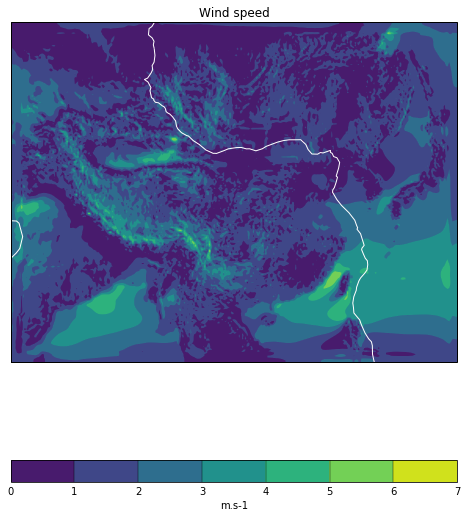

In [14]:
%%time
qplt.contourf(wind_speed_mean, cmap='viridis')
plt.gca().coastlines(color='white')
plt.gcf().set_size_inches(8,12)

In [15]:
xwind.

<iris 'Cube' of x_wind / (m s-1) (time: 77329; grid_latitude: 218; grid_longitude: 286)>